In [47]:
import os
import pypsa 
import matplotlib.pyplot as plt
plt.style.use("bmh")
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns  ###
import cartopy.crs as ccrs
sns.set(style='darkgrid') ### seaborn gives a nice design


In [48]:
cd /home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts/scripts


/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts/scripts


In [65]:
from _helpers import *



## Upload network

In [55]:
#current directory
%pwd

'/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling/Model_scripts/scripts'

In [56]:
#direct the correct folder with cd (linux)
%cd /home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling 

/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling


In [57]:
#check directory
%pwd 

'/home/max/OneDrive/PHD-Flexibility/08_2_SecondPaper/unintended-storage-cycling'

In [58]:
#Upload scneario
n = pypsa.Network("Model_scripts/results/networks/elec_s_16_ec_lv1.25_Co2L-1H-discharger+mc0.nc")

/home/max/anaconda3/envs/pypsa-eur/lib/python3.8/site-packages/pypsa/io.py:769: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=df.index | columns, fill_value=default)
/home/max/anaconda3/envs/pypsa-eur/lib/python3.8/site-packages/pypsa/io.py:771: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=(pnl[attr].columns | columns))
INFO:pypsa.io:Imported network elec_s_16_ec_lv1.25_Co2L-1H-discharger+mc0.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


## Pre-assessment

In [7]:
print("Marginal_costs", n.generators.marginal_cost.to_string(index=True), n.links.marginal_cost.to_string(index=True), n.stores.marginal_cost.to_string(index=True))
print()
print("Snapshots", len(n.snapshots))

Marginal_costs name
DE0 0 onwind         0.0
DE0 0 ror            0.0
DE0 0 solar          0.0
DE0 1 onwind         0.0
DE0 1 ror            0.0
DE0 1 solar          0.0
DE0 10 offwind-ac    0.0
DE0 10 onwind        0.0
DE0 10 ror           0.0
DE0 10 solar         0.0
DE0 11 onwind        0.0
DE0 11 ror           0.0
DE0 11 solar         0.0
DE0 12 onwind        0.0
DE0 12 ror           0.0
DE0 12 solar         0.0
DE0 13 offwind-ac    0.0
DE0 13 offwind-dc    0.0
DE0 13 onwind        0.0
DE0 13 ror           0.0
DE0 13 solar         0.0
DE0 14 onwind        0.0
DE0 14 ror           0.0
DE0 14 solar         0.0
DE0 15 onwind        0.0
DE0 15 ror           0.0
DE0 15 solar         0.0
DE0 2 onwind         0.0
DE0 2 ror            0.0
DE0 2 solar          0.0
DE0 3 onwind         0.0
DE0 3 ror            0.0
DE0 3 solar          0.0
DE0 4 onwind         0.0
DE0 4 ror            0.0
DE0 4 solar          0.0
DE0 5 offwind-ac     0.0
DE0 5 offwind-dc     0.0
DE0 5 onwind         0.0
DE0 5

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


(<matplotlib.collections.PatchCollection at 0x7f7a6576a640>,
 <matplotlib.collections.LineCollection at 0x7f7a63590340>)

/home/max/anaconda3/envs/pypsa-eur/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


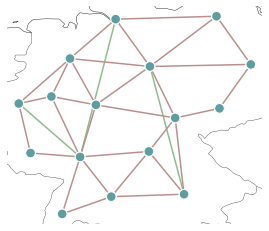

In [8]:
n.plot() #to check the spatial resolution

## Data preparation

### Amount of unintended cycling

The following steps are described below to detect unintended storage cycling:
1. Reading efficiencies
2. Create charging and discharging timeseries
3. Calculate amount of aggregated unintended storage cycling [MWh]
4. Summary outputs

#### 1. Reading efficiencies

In [9]:
costs = pd.read_csv("pypsa-eur-test1/data/costs.csv")
costs.head()

,technology,year,parameter,value,unit,source
0,solar-rooftop,2030,discount rate,0.04,per unit,standard for decentral
1,onwind,2030,lifetime,30.00,years,DEA https://ens.dk/en/our-services/projections...
2,offwind,2030,lifetime,30.00,years,DEA https://ens.dk/en/our-services/projections...
3,solar,2030,lifetime,25.00,years,IEA2010
4,solar-rooftop,2030,lifetime,25.00,years,IEA2010


In [10]:
##READING EFFICIENCY
costs = pd.read_csv("pypsa-eur-test1/data/costs.csv")
electrolysor_effi = costs.iloc[89]['value']
fuel_cell_effi = costs.iloc[93]['value']
battery_effi = costs.iloc[115]['value']

print(electrolysor_effi)
print(fuel_cell_effi)
print(battery_effi)

0.8
0.58
0.9


#### 2. Create charging and Discharging Timeseries

In [11]:
## CHARGING AND DISCHARGING TIMESERIES
    # p0 & p1 are related to charging
    # p2 & p3 are related to discharging
    # p0 * effi = p1

## Abbreviations
    #h2 = Hydrogen storage
    #b = battery storage
    
## REMOVES THE COLUMN INDEX (Code explanation)
    #.transpose().reset_index(drop = True, inplace = False).transpose()

p0_h2 = abs(n.links_t.p0.filter(like='Electrolysis', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
p1_h2 = abs(n.links_t.p1.filter(like='Electrolysis', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
p2_h2 = abs(n.links_t.p0.filter(like='Fuel Cell', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
p3_h2 = abs(n.links_t.p1.filter(like='Fuel Cell', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()

p0_b = abs(n.links_t.p0.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
p1_b = abs(n.links_t.p1.filter(like='battery charger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
p2_b = abs(n.links_t.p0.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()
p3_b = abs(n.links_t.p1.filter(like='battery discharger', axis='columns')).transpose().reset_index(drop = True, inplace = False).transpose()

In [25]:
df = pd.DataFrame(data=(p0_h2.sum(axis=1)), columns=['p0_h2'])
df['p1_h2'] = p1_h2.sum(axis=1)
df['p2_h2'] = p2_h2.sum(axis=1)
df['p3_h2'] = p3_h2.sum(axis=1)
df['p0_b'] = p0_b.sum(axis=1)
df['p1_b'] = p1_b.sum(axis=1)
df['p2_b'] = p2_b.sum(axis=1)
df['p3_b'] = p3_b.sum(axis=1)
df

,p0_h2,p1_h2,p2_h2,p3_h2,p0_b,p1_b,p2_b,p3_b
name,,,,,,,,
2013-01-01 00:00:00,48641.419047,38913.135238,6104.974171,3540.885019,6554.732079,5899.258871,5423.735206,4881.361685
2013-01-01 01:00:00,47981.020147,38384.816118,5982.775070,3470.009541,6524.215955,5871.794360,5459.141959,4913.227763
2013-01-01 02:00:00,46761.474382,37409.179506,6049.938853,3508.964535,6474.166817,5826.750135,5515.074001,4963.566601
2013-01-01 03:00:00,47327.542417,37862.033933,5946.613164,3449.035635,6506.965186,5856.268668,5480.569898,4932.512908
2013-01-01 04:00:00,46117.454907,36893.963925,6140.186203,3561.307998,6462.397877,5816.158089,5530.074217,4977.066795
...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,47868.460298,38294.768239,7360.105343,4268.861099,6189.771207,5570.794086,5799.117590,5219.205831
2013-12-31 20:00:00,48021.013273,38416.810619,7187.826489,4168.939363,6253.008844,5627.707960,5731.807012,5158.626311
2013-12-31 21:00:00,47964.115625,38371.292500,7059.732424,4094.644806,6246.710742,5622.039668,5741.212626,5167.091364


#### 3. Calculate amount of aggregated unintended storage cycling

In [13]:
## CHARGING AND DISCHARGING TIMESERIES
    # usc_h2 = timeseries of unintended storage cycling for hydrogen storage for all buses
    # usc_b = timeseries of unintended storage cycling for battery storage for all busses

## Abbreviations
    #h2 = Hydrogen storage
    #b = battery storage

## Number of required iterations
i = p0_h2.shape[1] # number of columns
j = p0_h2.shape[0] # number of rows

## Create empty dataframe

usc_h2 = pd.DataFrame(np.zeros((j, i))) #Artificial curtailment from USC in H2
usc_b = pd.DataFrame(np.zeros((j, i))) #Artificial curtailment from USC in Battery
p0_h2_corr = pd.DataFrame(np.zeros((j, i)))
p1_h2_corr = pd.DataFrame(np.zeros((j, i)))
p2_h2_corr = pd.DataFrame(np.zeros((j, i)))
p3_h2_corr = pd.DataFrame(np.zeros((j, i)))
p0_b_corr = pd.DataFrame(np.zeros((j, i)))
p1_b_corr = pd.DataFrame(np.zeros((j, i)))
p2_b_corr = pd.DataFrame(np.zeros((j, i)))
p3_b_corr = pd.DataFrame(np.zeros((j, i)))


#Charge and discharge should never happen at the same time, as it is equal to dissipating energy. 
#Dissipating energy in an energy storage is too expensive since it reduces the lifetime of these relative expensive devices.
#There are cheaper ways to dissipate energy such as curtailing VRE or using electric coils.

#Having charge and discharge at the same time is a signal USC exists.
for col in range(i):
    for row in range(j):
        if p1_h2[col][row] > p2_h2[col][row]: #Charge cycle
            usc_h2[col][row] = (p2_h2[col][row] - p3_h2[col][row]) + p2_h2[col][row] / electrolysor_effi
            p0_h2_corr[col][row] = p0_h2[col][row] - p2_h2[col][row] / electrolysor_effi
            p1_h2_corr[col][row] = p1_h2[col][row] - p2_h2[col][row]
            p2_h2_corr[col][row] = 0
            p3_h2_corr[col][row] = 0
        else: #Discharge cycle
            usc_h2[col][row] = (p0_h2[col][row] - p1_h2[col][row]) + p1_h2[col][row]*(1 - fuel_cell_effi) 
            p3_h2_corr[col][row] = p3_h2[col][row] - p1_h2[col][row] * fuel_cell_effi
            p2_h2_corr[col][row] = p2_h2[col][row] - p1_h2[col][row]
            p1_h2_corr[col][row] = 0
            p0_h2_corr[col][row] = 0
        if p1_b[col][row] > p2_b[col][row]: #Charge cycle
            usc_b[col][row] = (p2_b[col][row] - p3_b[col][row]) + p2_b[col][row] / battery_effi
            p0_b_corr[col][row] = p0_b[col][row] - p2_b[col][row] / battery_effi
            p1_b_corr[col][row] = p1_b[col][row] - p2_b[col][row]
            p2_b_corr[col][row] = 0
            p3_b_corr[col][row] = 0
        else: #Discharge cycle
            usc_b[col][row] = (p0_b[col][row] - p1_b[col][row]) + p1_b[col][row]*(1 - battery_effi)
            p3_b_corr[col][row] = p3_b[col][row] - p1_b[col][row] * battery_effi
            p2_b_corr[col][row] = p2_b[col][row] - p1_b[col][row]
            p1_b_corr[col][row] = 0
            p0_b_corr[col][row] = 0

In [29]:
#corrected timeseries
df['p0_h2_corr'] = p0_h2_corr.sum(axis=1).values
df['p1_h2_corr'] = p1_h2_corr.sum(axis=1).values
df['p2_h2_corr'] = p2_h2_corr.sum(axis=1).values
df['p3_h2_corr'] = p3_h2_corr.sum(axis=1).values
df['p0_b_corr'] = p0_b_corr.sum(axis=1).values
df['p1_b_corr'] = p1_b_corr.sum(axis=1).values
df['p2_b_corr'] = p2_b_corr.sum(axis=1).values
df['p3_b_corr'] = p3_b_corr.sum(axis=1).values
#USC curtailment (/Artificial curtailment). Shoulb be added to VRE curtailment or cheap dissipator
df['usc_h2'] = usc_h2.sum(axis=1).values
df['usc_b'] = usc_b.sum(axis=1).values
df

,p0_h2,p1_h2,p2_h2,p3_h2,p0_b,...,p1_b_corr,p2_b_corr,p3_b_corr,usc_h2,usc_b
name,,,,,,,,,,,
2013-01-01 00:00:00,48641.419047,38913.135238,6104.974171,3540.885019,6554.732079,...,479.895660,4.371995,3.934795,10195.306865,6397.876208
2013-01-01 01:00:00,47981.020147,38384.816118,5982.775070,3470.009541,6524.215955,...,416.379135,3.726734,3.354061,9991.234367,6441.295749
2013-01-01 02:00:00,46761.474382,37409.179506,6049.938853,3508.964535,6474.166817,...,415.124789,103.448655,93.103789,10103.397885,4007.360539
2013-01-01 03:00:00,47327.542417,37862.033933,5946.613164,3449.035635,6506.965186,...,427.291302,51.592532,46.433279,9930.843984,4005.245746
2013-01-01 04:00:00,46117.454907,36893.963925,6140.186203,3561.307998,6462.397877,...,421.674686,135.590813,122.031732,10254.110959,4001.623650
...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,47868.460298,38294.768239,7360.105343,4268.861099,6189.771207,...,57.711114,286.034618,257.431156,12291.375923,4357.703690
2013-12-31 20:00:00,48021.013273,38416.810619,7187.826489,4168.939363,6253.008844,...,65.193407,169.292459,152.363213,12003.670236,4548.608376
2013-12-31 21:00:00,47964.115625,38371.292500,7059.732424,4094.644806,6246.710742,...,65.158447,184.331405,165.898265,11789.753148,3917.059113


In [22]:
(p0_h2.sum(axis=1)-df['p0_h2_corr'])

name
2013-01-01 00:00:00    7631.217714
2013-01-01 01:00:00    7478.468837
2013-01-01 02:00:00    7562.423566
2013-01-01 03:00:00    7433.266455
2013-01-01 04:00:00    7675.232754
                          ...     
2013-12-31 19:00:00    9200.131679
2013-12-31 20:00:00    8984.783111
2013-12-31 21:00:00    8824.665530
2013-12-31 22:00:00    8458.883324
2013-12-31 23:00:00    8061.987798
Length: 8760, dtype: float64

## Plot Dataframe

In [168]:
#3 x columnn: p3_h2, p3_b, p3(agg) without USC correction (aggregated over all buses battery + H2 = different colors )
#3 x columns: p3_h2_corr, p3_b_corr, p3_agg_corr without USC correction ()

In [184]:
df_plot = pd.DataFrame(data=(p0_h2.sum(axis=1)), columns=['p0_h2'])
df_plot['power_output_H2'] = df['p3_h2'].values
df_plot['power_output_battery'] = df['p3_b'].values
df_plot['power_output_H2_and_battery'] = df_plot['power_output_battery'].values+df_plot['power_output_H2'].values
df_plot['power_output_H2_USC_corr'] = df['p3_h2_corr'].values
df_plot['power_output_battery_USC_corr'] = df['p3_b_corr'].values
df_plot['power_output_H2_and_battery_USC_corr'] = df_plot['power_output_H2_USC_corr'].values + df_plot['power_output_battery_USC_corr'].values

#eff.curtailment durring charging AND discharging
df_plot['usc_h2'] = df['usc_h2'].values
df_plot['usc_b'] = df['usc_b'].values

#Uncorrected power IN- and OUTPUT
df_plot['power_in_and_output_total'] = df['p0_h2'].values + df['p0_b'].values + df['p3_h2'].values + df['p3_b'].values

df_plot.reset_index()
df_plot

,p0_h2,power_output_H2,power_output_battery,power_output_H2_and_battery,power_output_H2_USC_corr,power_output_battery_USC_corr,power_output_H2_and_battery_USC_corr,usc_h2,usc_b,power_in_and_output_total
name,,,,,,,,,,
2013-01-01 00:00:00,48641.419047,3540.885019,4881.361685,8422.246704,0.0,3.934795,3.934795,10195.306865,6397.876208,63618.397830
2013-01-01 01:00:00,47981.020147,3470.009541,4913.227763,8383.237304,0.0,3.354061,3.354061,9991.234367,6441.295749,62888.473406
2013-01-01 02:00:00,46761.474382,3508.964535,4963.566601,8472.531136,0.0,93.103789,93.103789,10103.397885,4007.360539,61708.172335
2013-01-01 03:00:00,47327.542417,3449.035635,4932.512908,8381.548543,0.0,46.433279,46.433279,9930.843984,4005.245746,62216.056146
2013-01-01 04:00:00,46117.454907,3561.307998,4977.066795,8538.374793,0.0,122.031732,122.031732,10254.110959,4001.623650,61118.227577
...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,47868.460298,4268.861099,5219.205831,9488.066930,0.0,257.431156,257.431156,12291.375923,4357.703690,63546.298435
2013-12-31 20:00:00,48021.013273,4168.939363,5158.626311,9327.565674,0.0,152.363213,152.363213,12003.670236,4548.608376,63601.587792
2013-12-31 21:00:00,47964.115625,4094.644806,5167.091364,9261.736169,0.0,165.898265,165.898265,11789.753148,3917.059113,63472.562536


## Main Plot

Illustrates that handling USC matters.

In [291]:
week = 44 #range 1-53 in a year
x = week

<AxesSubplot:xlabel='name', ylabel='power_output_H2_and_battery'>

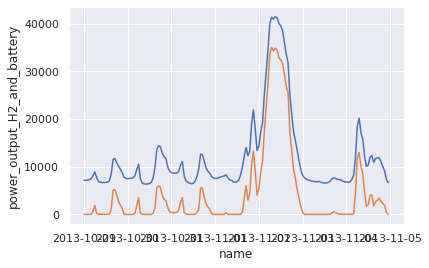

In [292]:
sns.lineplot(data=df_plot[(x-1)*168:(x)*168], x="name", y="power_output_H2_and_battery")
sns.lineplot(data=df_plot[(x-1)*168:(x)*168], x="name", y="power_output_H2_and_battery_USC_corr")

##USC just works when discharging is not already 100% (like in the summer)

<AxesSubplot:xlabel='name'>

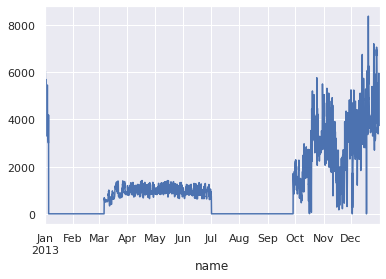

In [293]:

(- df_plot.power_output_H2_USC_corr + df_plot.power_output_H2).plot()

## Other plots

<AxesSubplot:xlabel='name', ylabel='usc_b'>

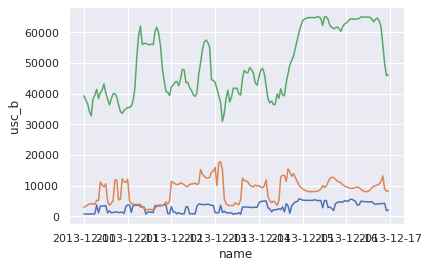

In [186]:
sns.lineplot(data=df[(x-1)*168:(x)*168], x="name", y="usc_b")
sns.lineplot(data=df[(x-1)*168:(x)*168], x="name", y="usc_h2")
#sns.lineplot(data=df_plot[(x-1)*168:(x)*168], x="name", y="power_output_H2_and_battery")
sns.lineplot(data=df_plot[(x-1)*168:(x)*168], x="name", y="power_in_and_output_total") 

Indicates how much % off the operational time is from USC
0.6751827261707013
0.40244172476488865
0.6287329894940876
0.5451491528617345
USC/Discharge 0.24738248563145596


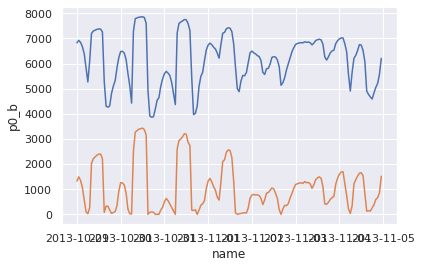

In [303]:
sns.lineplot(data=df[(x-1)*168:(x)*168], x="name", y="p0_b")
sns.lineplot(data=df[(x-1)*168:(x)*168], x="name", y="p0_b_corr")

print("Indicates how much % off the operational time is from USC")
print((1-df['p0_b_corr']/df['p0_b']).mean()) # in percentage
print((1-df['p0_h2_corr']/df['p0_h2']).mean())
print((1-df['p3_b_corr']/df['p3_b']).mean())
print((1-df['p3_h2_corr']/df['p3_h2']).mean())

print("USC/Discharge",(df['usc_h2'].mean()/df['p3_h2'].mean()))

In [300]:
df['usc_h2'].mean()
df['p3_h2'].mean()

10852.0402959672

In [213]:
print("FLH H2 with (=artificial) and without (=true) USC")
print("")
print("Discharger")
print((df['p3_h2']/df['p3_h2'].max()).mean()*8760)
print((df['p3_h2_corr']/df['p3_h2_corr'].max()).mean()*8760)
print("Charger")
print((df['p0_h2'].mean()*8760)/df['p0_h2'].max()) # Alternative formulation: FLH = Energy / P.max
print((df['p0_h2_corr'].mean()*8760)/df['p0_h2_corr'].max())
print("")
print("")
print("FLH Battery with (=artificial) and without (=true) USC")
print("")
print("Discharger")
print((df['p3_b']/df['p3_b'].max()).mean()*8760)
print((df['p3_b_corr']/df['p3_b_corr'].max()).mean()*8760)
print("Charger")
print((df['p0_b'].mean()*8760)/df['p0_b'].max()) # Alternative formulation: FLH = Energy / P.max
print((df['p0_b_corr'].mean()*8760)/df['p0_b_corr'].max()) 

FLH H2 with (=artificial) and without (=true) USC

Discharger
1862.5943984804594
1676.2515193865831
Charger
3357.0620455618573
3021.211471045141


FLH Battery with (=artificial) and without (=true) USC

Discharger
2573.8499922677133
1021.9834877600798
Charger
3177.643431669573
1261.7497259936404


## FIGURE 2 USC [%] timeseries

In [226]:
#USC in mean percentage timeseries #Same as (FLH Battery Artificial - FLH Battery True) / 8760 ->(3177-1262)/8760
((df['p0_b']-df['p0_b_corr'])/df['p0_b_corr'].max()).mean()

0.21871734859344757

<AxesSubplot:xlabel='name'>

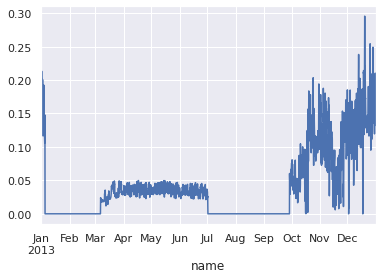

In [252]:
#USC distortion timeseries (charger h2)
((df['p0_h2']-df['p0_h2_corr'])/df['p0_h2_corr'].max()).plot()
#sns.lineplot(data=df[(x-1)*168:(x)*168], x="name", y="p0_b")

<AxesSubplot:xlabel='name'>

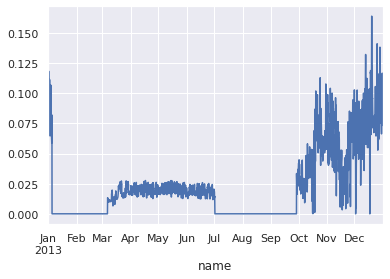

In [244]:
#USC distortion timeseries (discharger h2)
((df['p3_h2']-df['p3_h2_corr'])/df['p3_h2_corr'].max()).plot()
#sns.lineplot(data=df[(x-1)*168:(x)*168], x="name", y="p0_b")

<AxesSubplot:xlabel='name'>

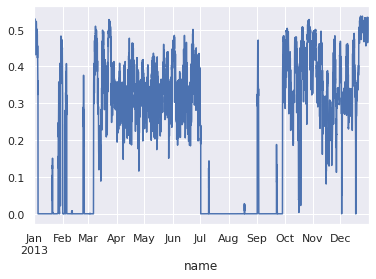

In [245]:
#USC distortion timeseries (charger battery)
((df['p0_b']-df['p0_b_corr'])/df['p0_b_corr'].max()).plot()
#sns.lineplot(data=df[(x-1)*168:(x)*168], x="name", y="p0_b")

<AxesSubplot:xlabel='name'>

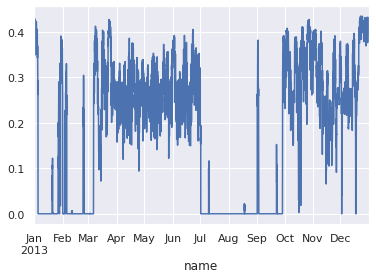

In [246]:
#USC distortion timeseries (discharger battery)
((df['p3_b']-df['p3_b_corr'])/df['p3_b_corr'].max()).plot()
#sns.lineplot(data=df[(x-1)*168:(x)*168], x="name", y="p0_b")